In [8]:
# =========================================================
# Core Python
# =========================================================
import os
import sys
import time
import random
import warnings
from pathlib import Path

# =========================================================
# Third-party scientific stack
# =========================================================
import numpy as np
import yaml

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm

# =========================================================
# LightPipes
# =========================================================
from LightPipes import *

# =========================================================
# VIBE
# =========================================================
import vibe.VIBE as vibe
from vibe.VIBE import flow_plot
import vibe.mmmUtils_v2 as mu
import vibe.rossendorfer_farbenliste as rofl


In [9]:
###################### PLOT DEFAULT PARAMETERS #####################
plt.rc('font',   size     =17)          # controls default text sizes
plt.rc('axes',   titlesize=17)          # fontsize of the axes title
plt.rc('axes',   labelsize=17)          # fontsize of the x and y labels
plt.rc('xtick',  labelsize=19)          # fontsize of the tick labels
plt.rc('ytick',  labelsize=19)          # fontsize of the tick labels
plt.rc('legend', fontsize =14)          # legend fontsize

Loading: /home/yu79deg/VIBE/VIBE_outputs/pickles/LP_940_figs.pickle
Loading scaling info: /home/yu79deg/VIBE/VIBE_outputs/pickles/LP_940_res.pickle
Available keys:
   • beam_shaper_main
   • flow_000_-10.00_main
   • flow_001_-9.70_main
   • flow_002_-9.40_main
   • flow_003_-9.10_main
   • CRL3_main
   • flow_004_-8.80_main
   • flow_005_-8.50_main
   • flow_006_-8.20_main
   • flow_007_-7.90_main
   • flow_008_-7.60_main
   • O1_main
   • flow_009_-7.30_main
   • flow_010_-7.00_main
   • flow_011_-6.70_main
   • flow_012_-6.40_main
   • flow_013_-6.10_main
   • flow_014_-5.80_main
   • flow_015_-5.50_main
   • flow_016_-5.20_main
   • flow_017_-4.90_main
   • flow_018_-4.60_main
   • flow_019_-4.30_main
   • flow_020_-4.00_main
   • flow_021_-3.70_main
   • flow_022_-3.40_main
   • flow_023_-3.10_main
   • flow_024_-2.80_main
   • flow_025_-2.50_main
   • flow_026_-2.20_main
   • flow_027_-1.90_main
   • flow_028_-1.60_main
   • flow_029_-1.30_main
   • CRL4a_main
   • flow_030_-1.00

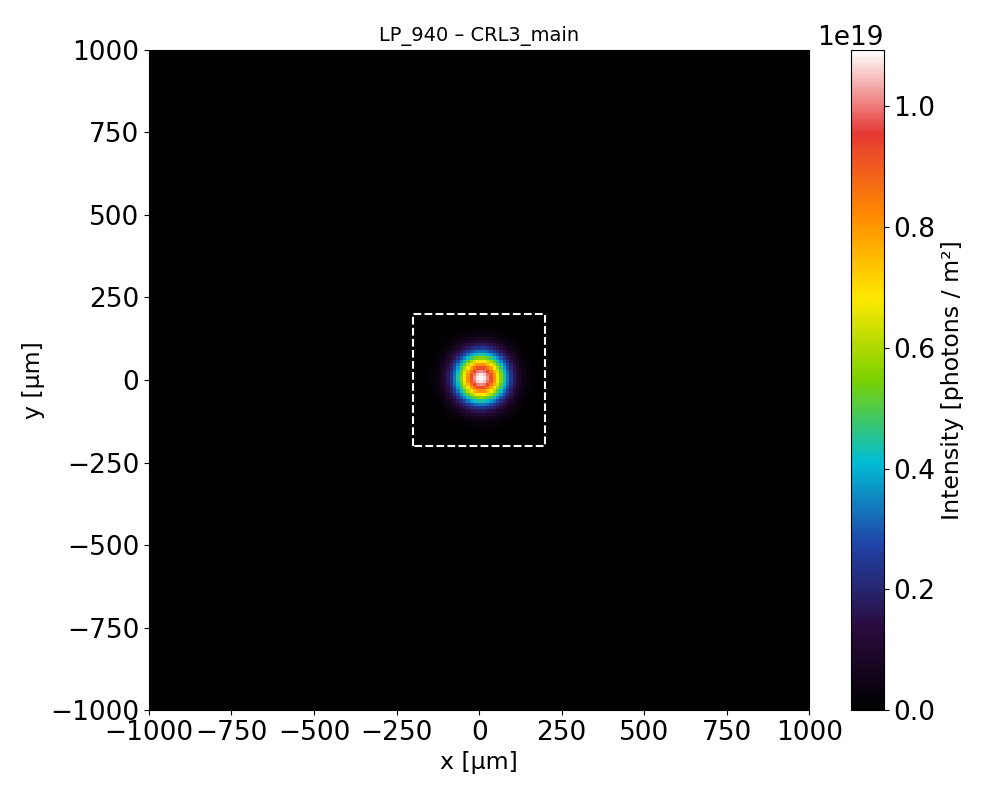

FWHM = 120.603 μm


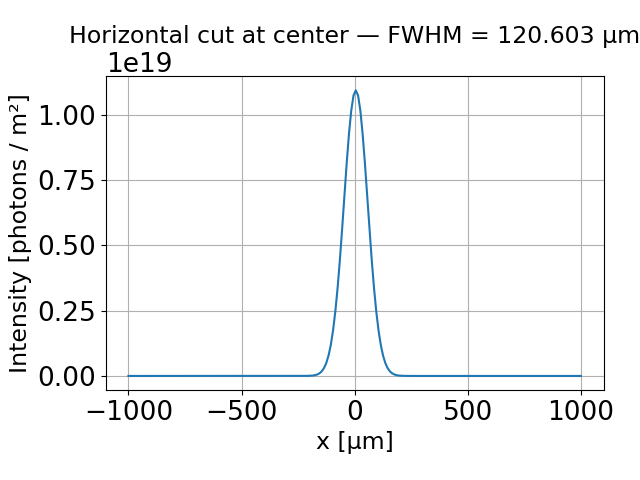

Integrated intensity over manual window: x=[-200.0,200.0] µm, y=[-200.0,200.0] µm: 1.870e+11 [photons / m²·m²]
→ Fraction of total photons in this region: 99.94%


In [11]:
###################### PLOT OF A GIVEN PLANE ####################
%matplotlib widget

# ----------------- USER PARAMETERS -----------------
project_dir = '/home/yu79deg/VIBE/VIBE_outputs'
yaml_tag = 'LP_940'  # Simulation name

plane_to_visualize  = 'CRL3_main'

# ----- Integration mode -----
# "Full" → integrate over full image
# float (e.g. 13e-6) → integrate within centered box of that size [m]
x_integ = 200.0   # e.g. 15   → integrate from -15 µm to +15 µm in x
y_integ = 200.0   # e.g. 25   → integrate from -25 µm to +25 µm in y
#integration_mode = 75e-6   # Integration range (examples: "Full" or 13e-6)
integration_mode = "Full"   # Integration range (examples: "Full" or 13e-6)

# ----- Choose unit -------
intensity_unit = 'photons'  # 'relative', 'photons', or 'Wcm2'

# ----- Display scaling -----
use_log = False
log_vmin_mode = "auto"


# -------------------- Load pickle files --------------------------

pickle_file = os.path.join(project_dir, 'pickles', f'{yaml_tag}_figs.pickle')
res_file = os.path.join(project_dir, 'pickles', f'{yaml_tag}_res.pickle')

print(f"Loading: {pickle_file}")
print(f"Loading scaling info: {res_file}")

res = mu.loadPickle(res_file)
params = res[1]

scale_ph = params.get('scale_phot', 1.0)
scale_Wcm2 = params.get('scale_Wcm2', 1.0)

if intensity_unit == 'photons':
    scale = scale_ph
    unit_label = 'photons / m²'
elif intensity_unit == 'Wcm2':
    scale = scale_Wcm2
    unit_label = 'W / m²'
else:
    scale = 1.0
    unit_label = 'a.u.'

figs = mu.loadPickle(pickle_file)

# -------------------- Display selected plane --------------------

use_manual_window = (x_integ is not None) and (y_integ is not None)

if plane_to_visualize not in figs:
    print(f"[error] '{plane_to_visualize}' not found in figs.")

    print("Available keys:")
    for k in list(figs.keys()):
        print("   •", k)

else:

    print("Available keys:")
    for k in list(figs.keys()):
        print("   •", k)


    data = figs[plane_to_visualize]      # [image, ei, propsize/ZoomFactor, z]
    img = data[0].astype(float)
    prop_size_m = float(data[2])         # physical box size (meters)
    N = img.shape[0]
    pixel_size_m = prop_size_m / N
    pixel_size_um = pixel_size_m * 1e6

    print(f"Selected plane: {plane_to_visualize}")
    print(f"N={N}, dx={pixel_size_um:.3f} µm, box={prop_size_m*1e6:.1f} µm")

    # Scale + extent
    img_scaled = img * scale
    extent = (-prop_size_m/2*1e6, prop_size_m/2*1e6,
              -prop_size_m/2*1e6, prop_size_m/2*1e6)

    # Norm (optional log)
    norm = None
    if use_log:
        pos = img_scaled > 0
        if np.any(pos):
            vmax = float(np.nanmax(img_scaled))
            vmin = (float(np.nanpercentile(img_scaled[pos], 0.1))
                    if log_vmin_mode == "auto" else float(log_vmin_mode))
            vmin = max(min(vmin, 0.99*vmax), np.finfo(float).tiny)
            from matplotlib.colors import LogNorm
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            print("[warn] No positive pixels, falling back to linear.")
            use_log = False

    # ---------------- PLOT IMAGE ----------------
    plt.figure(figsize=(10, 8))
    im = plt.imshow(img_scaled, cmap=rofl.cmap(), norm=norm,
                    extent=extent, origin='lower', aspect='equal')
    plt.title(f'{yaml_tag} – {plane_to_visualize}', fontsize=14)

    plt.xlabel('x [μm]'); plt.ylabel('y [μm]')
    plt.colorbar(im, label=f'Intensity [{unit_label}]')

    # Draw ROI if applicable
    if integration_mode != "Full":
        roi_size_m = float(integration_mode)
        half_box_um = roi_size_m * 1e6 / 2
        plt.plot([-half_box_um, -half_box_um, half_box_um, half_box_um, -half_box_um],
                 [-half_box_um, half_box_um, half_box_um, -half_box_um, -half_box_um],
                 'r--', lw=1.5)
        plt.title(f'{yaml_tag} – {plane_to_visualize}', fontsize=14)

    # Draw manual integration window
    if use_manual_window:
        xh = x_integ
        yh = y_integ
        xs = [-xh, -xh,  xh,  xh, -xh]
        ys = [-yh,  yh,  yh, -yh, -yh]
        plt.plot(xs, ys, 'w--', lw=1.5)


    plt.tight_layout()
    plt.show()

    # ---------------- LINEOUT + FWHM ----------------
    x_vals_um = np.linspace(extent[0], extent[1], img_scaled.shape[1])
    center_y = img_scaled.shape[0] // 2
    horizontal = img_scaled[center_y, :]

    plt.figure()
    if use_log:
        plt.semilogy(x_vals_um, np.maximum(horizontal, np.finfo(float).tiny))
    else:
        plt.plot(x_vals_um, horizontal)
    plt.xlabel('x [μm]'); plt.ylabel(f'Intensity [{unit_label}]')

    # FWHM computation
    I_line = horizontal
    if np.nanmax(I_line) > 0:
        I_norm = I_line / np.nanmax(I_line)
        half = 0.5
        above = I_norm >= half
        idx = np.where(above)[0]
        if idx.size >= 2:
            x_left, x_right = x_vals_um[idx[0]], x_vals_um[idx[-1]]
            fwhm = x_right - x_left
            plt.title(f'Horizontal cut at center — FWHM = {fwhm:.3f} μm')
            print(f"FWHM = {fwhm:.3f} μm")
        else:
            plt.title('Horizontal cut at center — FWHM undetermined')
            print("Could not determine FWHM (signal too weak or flat).")
    else:
        plt.title('Horizontal cut at center — all zeros')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---------------- INTEGRATION ----------------

    if use_manual_window:
        # Convert microns → pixels
        x_half_px = int((x_integ * 1e-6) / pixel_size_m)
        y_half_px = int((y_integ * 1e-6) / pixel_size_m)

        cx = cy = N // 2
        x0, x1 = cx - x_half_px, cx + x_half_px
        y0, y1 = cy - y_half_px, cy + y_half_px

        # Clip if boundaries exceed image size
        x0 = max(0, x0); x1 = min(N, x1)
        y0 = max(0, y0); y1 = min(N, y1)

        sub_img = img_scaled[y0:y1, x0:x1]
        region_desc = (f"manual window: x=[-{x_integ},{x_integ}] µm, "
                       f"y=[-{y_integ},{y_integ}] µm")

    elif integration_mode == "Full":
        sub_img = img_scaled
        region_desc = "full image"

    elif isinstance(integration_mode, (float, int)):
        roi_size_m = float(integration_mode)
        center_px = N // 2
        half_roi_px = int((roi_size_m / pixel_size_m) / 2)
        x0, x1 = center_px - half_roi_px, center_px + half_roi_px
        y0, y1 = center_px - half_roi_px, center_px + half_roi_px
        sub_img = img_scaled[y0:y1, x0:x1]
        region_desc = f"{roi_size_m*1e6:.1f} µm × {roi_size_m*1e6:.1f} µm centered ROI"

    else:
        raise ValueError("integration_mode must be 'Full', a number, "
                         "or use manual window parameters x_integ/y_integ.")

    # Compute integrated value
    sum_map = np.nansum(sub_img)
    integrated_value = sum_map * (pixel_size_m**2)
    print(f"Integrated intensity over {region_desc}: {integrated_value:.3e} [{unit_label}·m²]")

    # Optional: fraction of total signal
    total_full = np.nansum(img_scaled) * (pixel_size_m**2)
    if (use_manual_window or integration_mode != "Full") and total_full > 0:
        fraction = integrated_value / total_full * 100
        print(f"→ Fraction of total photons in this region: {fraction:.2f}%")

